# Integración Simpléctica - Método Stormer Verlet

Se declara la variedad simpléctica y la carta:

In [41]:
n = 2 #cantidad de grados de libertad
M=Manifold(2*n, name='M')

In [42]:
std.<x,y,px,py>=M.chart('x y px py')

Se declaran parámetros y Hamiltonianos:

$$
H(\mathbf{q},\mathbf{p}) = H_T(\mathbf{p}) + H_V(\mathbf{q})
$$


In [43]:
m = 1
g = 10

In [44]:
H_V = M.scalar_field( m*g*y , name='H_V' )

In [45]:
H_T = M.scalar_field( (px^2 +py^2)/(2*m)  , name='H_T' )

In [46]:
from sage.manifolds.operators import *

In [52]:
M.dimension()

4

In [63]:
M.default_frame()

Coordinate frame (M, (∂/∂x,∂/∂y,∂/∂px,∂/∂py))

Recordemos que tenemos el isomorfismo ($\omega^{\sharp}$ se ve muy feo entonces lo pongo como $\beta$)
$$
\begin{align*}
  \beta \colon TM & \longrightarrow T^{*}M \\
  a_\alpha \frac{\partial}{\partial q_\alpha} +  b_\alpha \frac{\partial}{\partial p_\alpha} & \longmapsto 
  b_\alpha dq_\alpha - a_\alpha dp_\alpha
\end{align*}
$$
el cual es facilmente invertible para que nos de la conexión entre los diferenciales de $H_V$ y $H_T$ con sus respectivos campos vectoriales hamiltonianos, los cuales después usaremos para obtener los flows asociados con los hamiltonianos $H_V$, $H_T$.
$$
\begin{align*}
  \beta^{-1} \colon T^{*}M & \longrightarrow T^{*}M \\
  a_\alpha dq_\alpha + b_\alpha dp_\alpha & \longmapsto -b_\alpha \frac{\partial}{\partial q_\alpha}+ a_\alpha \frac{\partial}{\partial p_\alpha}
  \end{align*}
$$
Pasamos ahora a definir $\beta^{-1}$ en Sage con el nombre de beta_inverse 

In [75]:
'''Función que recibe una 1-forma(diferencial) y retorna un campo vectorial. El campo es definido en el frame por 
    defecto de la variedad M sobre la que está definida la forma'''
def beta_inverse(M, alpha):
    e = M.default_frame()
    ##hasta donde revisé, no hay una forma más simple de acceder a los componentes de la forma.
    ##Me faltó revisar la documentación de campos tensoriales, a lo mejor allá hablan algo de eso.
    #OJO: Se asume que la variedad es de dimensión par y el marco por defecto es la base canónica.
    n= M.dimension()
    X_alpha_q = sum(-alpha(e[i])*e[i] for i in range(0,n/2))
    X_alpha_p = sum(alpha(e[i+n/2])*e[i+n/2] for i in range(0,n/2))
    X_alpha = X_alpha_q + X_alpha_p
    return X_alpha

In [77]:
beta_inverse(M, dH_V).display()

-dH_V(∂/∂x)*∂/∂x+-dH_V(∂/∂y)*∂/∂y+dH_V(∂/∂px)*∂/∂px+dH_V(∂/∂py)*∂/∂py = -10 ∂/∂y

Se realiza la derivada exterior de los hamiltonianos y sus coeficientes se acomodan para obtener los campos hamiltonianos $ \mathbf{X_T} $ y $ \mathbf{X_V} $.

In [66]:
dH_V = H_V.differential()

In [79]:
dH_T = H_T.differential()

In [10]:
X_T = sum(-dH_V(e[i])*e[i+2] for i in (0,1))

In [11]:
X_V = sum(dH_T(e[i+2])*e[i] for i in (0,1))

In [12]:
X_T.display()

-dH_V(∂/∂x)*∂/∂px+-dH_V(∂/∂y)*∂/∂py = -10 ∂/∂py

In [13]:
X_V.display()

dH_T(∂/∂px)*∂/∂x+dH_T(∂/∂py)*∂/∂y = px ∂/∂x + py ∂/∂y

Prueba: pilla que con beta_inverse sí se obtienen los mismos campos que manualmente

In [81]:
beta_inverse(M, dH_T).display()

-dH_T(∂/∂x)*∂/∂x+-dH_T(∂/∂y)*∂/∂y+dH_T(∂/∂px)*∂/∂px+dH_T(∂/∂py)*∂/∂py = px ∂/∂px + py ∂/∂py

In [82]:
beta_inverse(M, dH_V).display()

-dH_V(∂/∂x)*∂/∂x+-dH_V(∂/∂y)*∂/∂y+dH_V(∂/∂px)*∂/∂px+dH_V(∂/∂py)*∂/∂py = -10 ∂/∂y

Stormer Verlet

$$
  \exp \left( \frac{1}{2} \Delta t X_V \right) \exp \left( \Delta t X_T \right)\exp \left( \frac{1}{2} \Delta t X_V \right)
$$

In [14]:
from sage.calculus.desolvers import desolve_odeint

dT=0.001

x0 = 10
y0 = 0
px0 = 1
py0 = 1

x,y,px,py = var('x,y,px,py')

sol1 = desolve_odeint([X_V[0].expr()/2,X_V[1].expr()/2,X_V[2].expr()/2,X_V[3].expr()/2],[x0,y0,px0,py0],srange(0,2*dT,dT),[x,y,px,py])



In [15]:
from sage.calculus.desolvers import desolve_odeint

dT=0.01

x0 = 0
y0 = 0
px0 = 1
py0 = 1

x,y,px,py = var('x,y,px,py')

sol2 = desolve_odeint([X_T[0].expr(),X_T[1].expr(),X_T[2].expr(),X_T[3].expr()],sol1[1,:],srange(0,2*dT,dT),[x,y,px,py])

In [16]:
from sage.calculus.desolvers import desolve_odeint

dT=0.001

x0 = 0
y0 = 0
px0 = 1
py0 = 1

x,y,px,py = var('x,y,px,py')

sol3 = desolve_odeint([X_V[0].expr()/2,X_V[1].expr()/2,X_V[2].expr()/2,X_V[3].expr()/2],sol2[1,:],srange(0,2*dT,dT),[x,y,px,py])

In [17]:
from sage.calculus.desolvers import desolve_odeint
import numpy as np

dT=0.001

x0 = 0
y0 = 10
px0 = 1
py0 = 1

x,y,px,py = var('x,y,px,py')

t=10

sol = np.zeros((int(t/dT),4))

for i in range(0,int(t/dT)):
    sol1 = desolve_odeint([X_V[0].expr()/2,X_V[1].expr()/2,X_V[2].expr()/2,X_V[3].expr()/2],[x0,y0,px0,py0],srange(0,2*dT,dT),[x,y,px,py])
    sol2 = desolve_odeint([X_T[0].expr(),X_T[1].expr(),X_T[2].expr(),X_T[3].expr()],sol1[1,:],srange(0,2*dT,dT),[x,y,px,py])
    sol3 = desolve_odeint([X_V[0].expr()/2,X_V[1].expr()/2,X_V[2].expr()/2,X_V[3].expr()/2],sol2[1,:],srange(0,2*dT,dT),[x,y,px,py])
    x0 = sol3[1,0]
    y0 = sol3[1,1]
    px0 = sol3[1,2]
    py0 = sol3[1,3]
    sol[i,:] = sol3[1,:]
    
print(sol)

[[ 1.00000000e-03  1.00009950e+01  1.00000000e+00  9.90000000e-01]
 [ 2.00000000e-03  1.00019800e+01  1.00000000e+00  9.80000000e-01]
 [ 3.00000000e-03  1.00029550e+01  1.00000000e+00  9.70000000e-01]
 ...
 [ 9.99800000e+00 -4.79802020e+02  1.00000000e+00 -9.89800000e+01]
 [ 9.99900000e+00 -4.79901005e+02  1.00000000e+00 -9.89900000e+01]
 [ 1.00000000e+01 -4.80000000e+02  1.00000000e+00 -9.90000000e+01]]


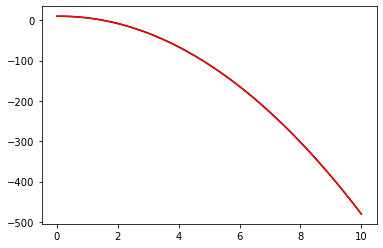

In [19]:
import matplotlib.pyplot as plt

t1 = np.linspace(0,t,int(t/dT))

plt.plot(sol[:,0],sol[:,1],'k')
plt.plot(t1, -t1**2 *(g/2) + t1 + 10,'r')
plt.show()
